In [2]:
import numpy as np
import qutip as qp
import matplotlib as mpl
import matplotlib.pyplot as plt

import lmfit

from pnc6.simlib.setup_pitch import PncRunner, Compute_pitch_simple, Predict_pitch_simple, Compute_catch_simple
from pnc6.simlib.setup_helpers import normalize_b

fname = 'g_test' #name of .npz g values file

%matplotlib inline
twopi = 2*np.pi
MHz = 1e-3
kHz = 1e-6
us = 1e3

In [3]:
def cos_pwr(x, amp, ofs, T, x0, pwr):
    model = (1. - np.cos((x - x0) * np.pi / (T))**pwr) * amp + ofs
    model[x < x0] = 0
    model[x > x0 + T] = 0
    return model

t_label = r't ($\mathrm{\mu s}$)'
g_label = r'$g/2\pi$ (kHz)'
a_label = 'Storage occupation (photon)'

## Prepare system parameters and desired output wavepacket form

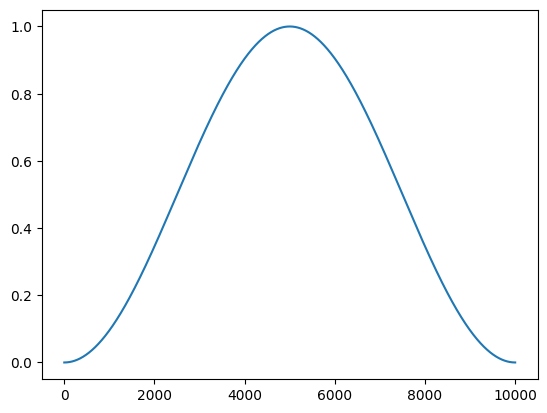

In [4]:
T = 10e3 # ns, fencepost
tlist = np.arange(0, T)

# system parameters
fit_g_params = lmfit.Parameters()
fit_g_params.add('ofs',   0)
fit_g_params.add('a11',   1)
fit_g_params.add('a13',   0)
fit_g_params.add('a31',   0)

params = {
    'kappa' : twopi * 1 * MHz,
    'chi_aa' : 0.,
    'chi_bb' : 0.,
    'chi_ab' : 0.,
    'fit_g_params' : fit_g_params,
    'na' : 1.,
    'nb' : 1.,
    'b_amp' : .2,
    'delta_b' : 0.,
    'delta_a' : 0.,
}

# the shape of the wavepacket we wish to pitch
b_out = cos_pwr(tlist, 1, 0, T, 0, 2)

plt.plot(tlist, b_out)

## Calculate pitch waveform

Initializing setup at 15:52:21
Initialization finished at 15:52:21 in 0 seconds
Starting solver at 15:52:21
Running simulation at 15:52:24
Solver finished at 15:52:24 in 2 seconds


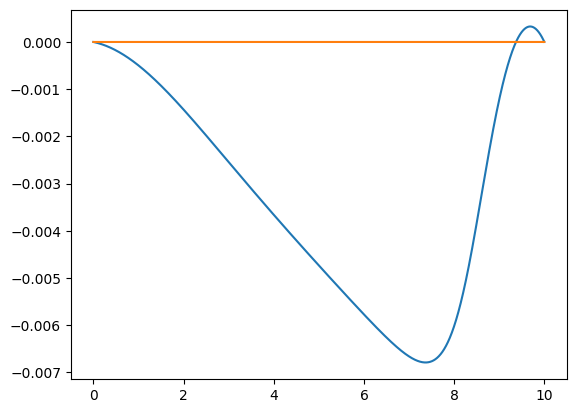

In [14]:
n_out = 0.99 # the fraction of energy we wish to release
runner = PncRunner(Compute_pitch_simple, 
                    nout = n_out,
                    tlist = tlist,
                    system_params = params,
                    b_out_shape = b_out,
                    simulate=True,
                    silent=False)

runner.run()
pitch = runner.setup

fig, ax = plt.subplots()
ax.plot(tlist/us, pitch.drive_a.real)
ax.plot(tlist/us, pitch.drive_a.imag)

Text(0, 0.5, '$g/2\\pi$ (kHz)')

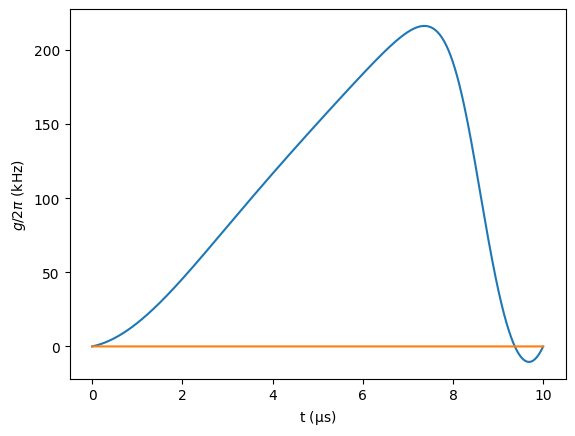

In [15]:
# the above is in some arbitrary units - convert to physical swap rate g
g_pitch = pitch.get_g(tlist)/twopi/kHz

fig, ax = plt.subplots()
ax.plot(tlist/us, g_pitch.real)
ax.plot(tlist/us, g_pitch.imag)

ax.set_xlabel(t_label)
ax.set_ylabel(g_label)

### Check the pitch

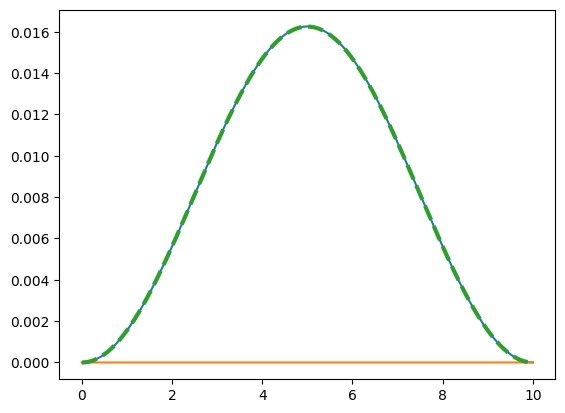

In [7]:
fig, ax = plt.subplots()
ax.plot(tlist/us, pitch.sim.b_out.real)
ax.plot(tlist/us, pitch.sim.b_out.imag)
ax.plot(tlist/us, normalize_b(b_out, tlist, n_out) , ls='--', lw=3)

## Calculate catch waveform

Initializing setup at 15:42:06
Initialization finished at 15:42:06 in 0 seconds
Starting solver at 15:42:06
Running simulation at 15:42:11
Solver finished at 15:42:12 in 5 seconds


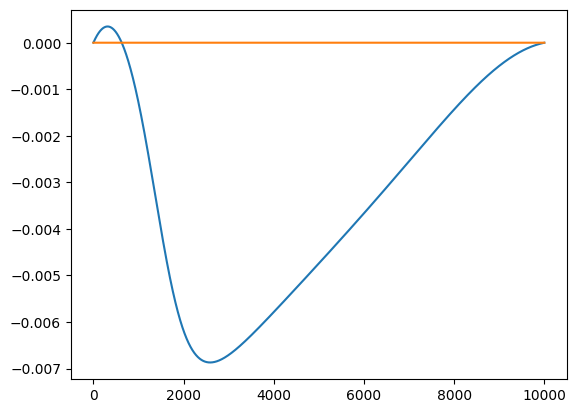

In [8]:
# catch
n_in = 0.99 # the fraction of energy we wish to capture
runner = PncRunner(Compute_catch_simple, 
                    nout = n_in,
                    tlist = tlist,
                    system_params = params,
                    b_out_shape = -pitch.sim.b_out,
                    simulate=True,
                    silent=False)

runner.run()
catch = runner.setup

plt.plot(tlist, catch.drive_a.real)
plt.plot(tlist, catch.drive_a.imag)

Text(0, 0.5, '$g/2\\pi$ (kHz)')

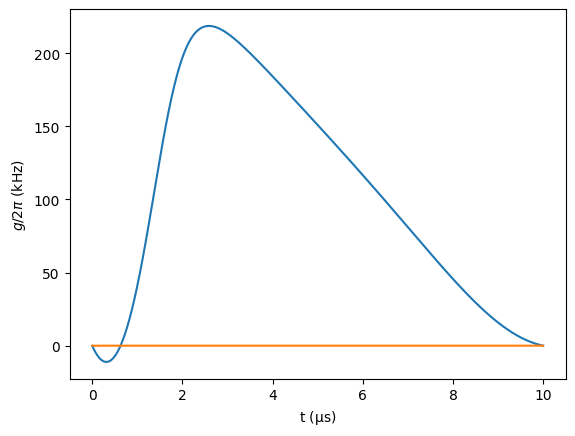

In [9]:
g_catch = catch.get_g(tlist)/twopi/kHz

fig, ax = plt.subplots()
ax.plot(tlist/us, g_catch.real)
ax.plot(tlist/us, g_catch.imag)

ax.set_xlabel(t_label)
ax.set_ylabel(g_label)

### Check the catch

0.9823720471895652


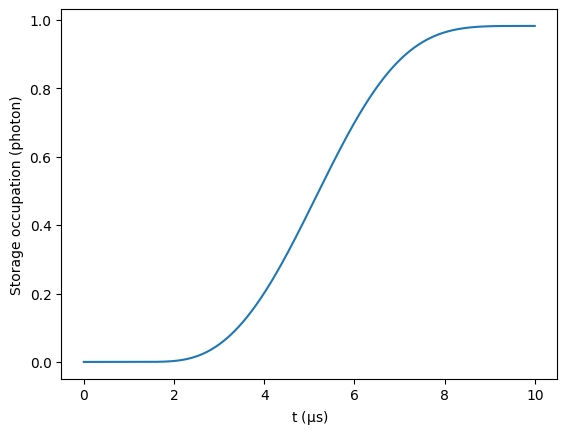

In [10]:
n_a = np.abs(catch.sim.a)**2
max_a = n_a.max()

fig, ax = plt.subplots()
ax.plot(tlist/us, n_a)

ax.set_xlabel(t_label)
ax.set_ylabel(a_label)

print(max_a)

### Save g values

In [78]:
np.save(r'g_vals/'+fname+'.npy',np.vstack((g_pitch,g_catch)))